In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install split-folders


Copying files: 366 files [00:19, 140.47 files/s]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders

# Path to your dataset folder
input_folder = "/kaggle/input/recycle"

# Split the dataset
splitfolders.ratio(input_folder, output="output_folder", 
                   seed=42, ratio=(.7, .15, .15), group_prefix=None)



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:01,  1.22s/ files]
Copying files: 150 files [00:01, 157.43 files/s]
Copying files: 295 files [00:01, 326.07 files/s]
Copying files: 409 files [00:01, 340.05 files/s]
Copying files: 493 files [00:02, 251.94 files/s]
Copying files: 552 files [00:02, 224.11 files/s]
Copying files: 597 files [00:02, 208.79 files/s]
Copying files: 633 files [00:03, 196.83 files/s]
Copying files: 662 files [00:03, 189.25 files/s]
Copying files: 687 files [00:03, 180.74 files/s]
Copying files: 709 files [00:03, 176.84 files/s]
Copying files: 730 files [00:03, 175.15 files/s]
Copying files: 750 files [00:03, 170.17 files/s]
Copying files: 768 files [00:03, 171.51 files/s]
Copying files: 786 files [00:04, 167.20 files/s]
Copying files: 804 files [00:04, 164.42 files/s]
Copying files: 821 files [00:04, 160.29 files/s]
Copying files: 838 files [00:04, 157.92 files/s]
Copying files: 855 files [00:04, 159.46 files/s]
Copying files: 872 files [00:

In [5]:
splitfolders.fixed(input_folder, output="output_folder", 
                   seed=42, fixed=(100, 50, 50), oversample=False)



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:01,  1.35s/ files]
Copying files: 130 files [00:01, 123.69 files/s]
Copying files: 206 files [00:03, 72.91 files/s] 
Copying files: 346 files [00:03, 150.90 files/s]
Copying files: 428 files [00:04, 86.72 files/s] 
Copying files: 574 files [00:05, 148.76 files/s]
Copying files: 800 files [00:07, 111.32 files/s]


## RESNET50


In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict

# Check for CPU/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transforms with more data augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets from their respective folders
train_data = datasets.ImageFolder(root="/kaggle/working/output_folder/train", transform=train_transform)
test_data = datasets.ImageFolder(root="/kaggle/working/output_folder/test", transform=test_transform)
val_data = datasets.ImageFolder(root="/kaggle/working/output_folder/val", transform=test_transform)

# Create DataLoaders
trainDataLoader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
testDataLoader = DataLoader(dataset=test_data, batch_size=32, shuffle=True)
valDataLoader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)

# Load Pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Unfreeze the last few layers for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Custom classifier for 4 classes with more layers
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p=0.3)),
    ('fc2', nn.Linear(1024, 512)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.3)),
    ('fc3', nn.Linear(512, 4)),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the pre-trained model's classifier with the custom classifier
model.fc = classifier

# Move the model to the device (GPU/CPU)
model.to(device)

# Define Loss with optional class weighting (use only if there's class imbalance)
# Example: class_weights = torch.tensor([1.0, 1.2, 0.8, 1.5]).to(device)  # Adjust weights as per class distribution
# criterion = nn.NLLLoss(weight=class_weights)
criterion = nn.NLLLoss()

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training parameters
epochs = 30
train_losses, val_losses, val_accuracies = [], [], []

# Training Loop
print("Starting Model Training...")

for epoch in range(epochs):
    running_loss = 0
    model.train()  # Set model to training mode
    
    correct_train = 0
    total_train = 0
    for images, labels in trainDataLoader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation
    val_loss = 0
    accuracy = 0
    correct_val = 0
    total_val = 0
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for images, labels in valDataLoader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            val_loss += criterion(logps, labels).item()
            
            # Validation accuracy
            ps = torch.exp(logps)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            total_val += labels.size(0)
            correct_val += (top_class == labels.view(*top_class.shape)).sum().item()

    # Log training and validation results
    train_losses.append(running_loss / len(trainDataLoader))
    val_losses.append(val_loss / len(valDataLoader))
    val_accuracies.append(accuracy / len(valDataLoader))

    print(f"Epoch: {epoch+1}/{epochs}.. "
          f"Training Loss: {running_loss / len(trainDataLoader):.3f}.. "
          f"Validation Loss: {val_loss / len(valDataLoader):.3f}.. "
          f"Validation Accuracy: {accuracy / len(valDataLoader):.3f}.. "
          f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
    
    # Step the scheduler
    scheduler.step()

# After training
print("\nTraining Complete!")

# Test the model on the test set
model.eval()
test_loss = 0
test_accuracy = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device)
        logps = model(images)
        test_loss += criterion(logps, labels).item()
        
        # Test accuracy
        ps = torch.exp(logps)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        total_test += labels.size(0)
        correct_test += (top_class == labels.view(*top_class.shape)).sum().item()

print(f"Test Loss: {test_loss / len(testDataLoader):.3f}.. "
      f"Test Accuracy: {100 * correct_test / total_test:.2f}%")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


Starting Model Training...
Epoch: 1/30.. Training Loss: 0.623.. Validation Loss: 0.398.. Validation Accuracy: 0.854.. Training Accuracy: 76.17%
Epoch: 2/30.. Training Loss: 0.350.. Validation Loss: 0.348.. Validation Accuracy: 0.876.. Training Accuracy: 87.33%
Epoch: 3/30.. Training Loss: 0.280.. Validation Loss: 0.294.. Validation Accuracy: 0.899.. Training Accuracy: 89.89%
Epoch: 4/30.. Training Loss: 0.228.. Validation Loss: 0.280.. Validation Accuracy: 0.900.. Training Accuracy: 91.99%
Epoch: 5/30.. Training Loss: 0.188.. Validation Loss: 0.306.. Validation Accuracy: 0.907.. Training Accuracy: 93.50%
Epoch: 6/30.. Training Loss: 0.159.. Validation Loss: 0.296.. Validation Accuracy: 0.910.. Training Accuracy: 94.62%
Epoch: 7/30.. Training Loss: 0.151.. Validation Loss: 0.309.. Validation Accuracy: 0.905.. Training Accuracy: 94.69%
Epoch: 8/30.. Training Loss: 0.092.. Validation Loss: 0.256.. Validation Accuracy: 0.919.. Training Accuracy: 96.94%
Epoch: 9/30.. Training Loss: 0.057.. 

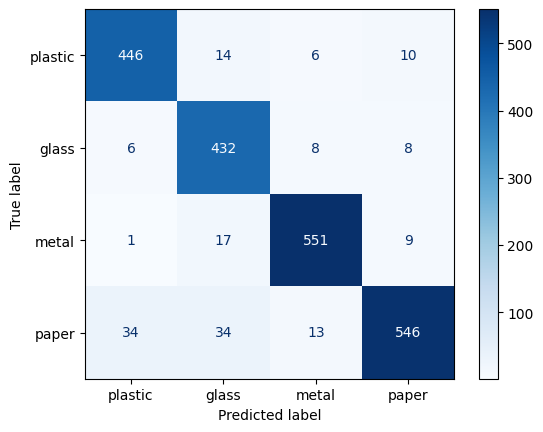

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is trained and you have the DataLoader for test data
# testDataLoader = DataLoader(test_data, batch_size=32, shuffle=True)

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
all_preds = []
all_labels = []

# Loop through test data to get predictions
with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        logps = model(images)
        ps = torch.exp(logps)
        
        # Get the predicted class with the highest probability
        _, predicted_classes = torch.max(ps, 1)
        
        # Store predicted and true labels
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define class names (e.g., 'plastic', 'glass', 'metal', 'paper')
class_names = ['plastic', 'glass', 'metal', 'paper']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

# Display the confusion matrix plot
plt.show()


In [8]:
from PIL import Image
import torch
from torchvision import transforms

# Function to predict the class of a single image
def predict_image(image_path, model, device):
    # Define the same transforms as used for test data
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the image
    image = Image.open(image_path)
    
    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the image to the device (GPU/CPU)
    image = image.to(device)
    
    # Set model to evaluation mode and turn off gradients
    model.eval()
    with torch.no_grad():
        # Forward pass
        logps = model(image)
        ps = torch.exp(logps)
        
        # Get the predicted class
        top_p, top_class = ps.topk(1, dim=1)
    
    return top_class.item(), top_p.item()

# Example usage:
image_path = '/kaggle/input/recycle/glass/glass_0018.jpg'  # Replace with your image path
predicted_class, probability = predict_image(image_path, model, device)

# Define class names (corresponding to the 4 classes in your model)
class_names = ['glass', 'metal', 'paper', 'plastic']

# Print the result
print(f"Predicted Class: {class_names[predicted_class]}")
print(f"Probability: {probability:.4f}")


Predicted Class: glass
Probability: 1.0000


In [9]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Initialize lists to store true labels and predictions for the test set
true_labels = []
pred_labels = []

# Test the model on the test set and collect predictions
model.eval()
test_loss = 0
test_accuracy = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device)
        logps = model(images)
        test_loss += criterion(logps, labels).item()
        
        # Get the predicted class
        ps = torch.exp(logps)
        _, top_class = ps.topk(1, dim=1)
        
        # Flatten the predictions and labels to lists
        pred_labels.extend(top_class.view(-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # Test accuracy
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        total_test += labels.size(0)
        correct_test += (top_class == labels.view(*top_class.shape)).sum().item()

# Print test accuracy
print(f"Test Loss: {test_loss / len(testDataLoader):.3f}.. "
      f"Test Accuracy: {100 * correct_test / total_test:.2f}%")

# Compute precision, recall, F1 score, and accuracy
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print a detailed classification report
report = classification_report(true_labels, pred_labels, target_names=test_data.classes)
print("Classification Report:\n", report)


Test Loss: 0.326.. Test Accuracy: 92.51%
Accuracy: 92.51%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Classification Report:
               precision    recall  f1-score   support

       glass       0.92      0.94      0.93       476
       metal       0.87      0.95      0.91       454
       paper       0.95      0.95      0.95       578
     plastic       0.95      0.87      0.91       627

    accuracy                           0.93      2135
   macro avg       0.92      0.93      0.92      2135
weighted avg       0.93      0.93      0.93      2135



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy

# Check for available device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Data Preprocessing (with Data Augmentation)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Step 2: Load the dataset from respective directories
data_dir = '/kaggle/working/output_folder'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val', 'test']}

# Create data loaders
batch_size = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Step 3: Load VGG19 pre-trained model
model = models.vgg19(pretrained=True)

# Unfreeze last few convolutional layers for fine-tuning
for param in model.features[-8:].parameters():
    param.requires_grad = True

# Modify the classifier to include more layers and handle shape mismatch
num_features = model.classifier[0].in_features  # This is 25088 for VGG19

model.classifier = nn.Sequential(
    nn.Linear(num_features, 4096),  # Match VGG19 output size
    nn.ReLU(),
    nn.Dropout(0.5),                # Dropout to prevent overfitting
    nn.Linear(4096, 1024),          # Added an additional FC layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 4)              # Final output layer for 4 classes
)

# Move the model to GPU if available
model = model.to(device)

# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with weight decay to regularize the model and reduce overfitting
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Step 5: Training and Validation Function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Step 6: Train the model
model = train_model(model, criterion, optimizer, num_epochs=25)

# Step 7: Evaluate the Model on the Test Set
def evaluate_model(model):
    model.eval()  # Set model to evaluate mode
    running_corrects = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Acc: {test_acc:.4f}')

# Evaluate the model on test set
evaluate_model(model)

# Step 8: Save the trained model
# torch.save(model.state_dict(), 'vgg19_transfer_learning_with_extra_layers.pth')


Epoch 0/24
----------
train Loss: 0.7317 Acc: 0.7234
val Loss: 0.6002 Acc: 0.7731
Epoch 1/24
----------
train Loss: 0.4811 Acc: 0.8289
val Loss: 0.4494 Acc: 0.8365
Epoch 2/24
----------
train Loss: 0.3739 Acc: 0.8664
val Loss: 0.3569 Acc: 0.8816
Epoch 3/24
----------
train Loss: 0.3466 Acc: 0.8760
val Loss: 0.3849 Acc: 0.8680
Epoch 4/24
----------
train Loss: 0.2748 Acc: 0.9007
val Loss: 0.5543 Acc: 0.8384
Epoch 5/24
----------
train Loss: 0.2526 Acc: 0.9106
val Loss: 0.3007 Acc: 0.8924
Epoch 6/24
----------
train Loss: 0.2355 Acc: 0.9186
val Loss: 0.4254 Acc: 0.8596
Epoch 7/24
----------
train Loss: 0.1802 Acc: 0.9360
val Loss: 0.3622 Acc: 0.8896
Epoch 8/24
----------
train Loss: 0.1839 Acc: 0.9365
val Loss: 0.3632 Acc: 0.8920
Epoch 9/24
----------
train Loss: 0.1707 Acc: 0.9421
val Loss: 0.3492 Acc: 0.8901
Epoch 10/24
----------
train Loss: 0.1557 Acc: 0.9476
val Loss: 0.3462 Acc: 0.8967
Epoch 11/24
----------
train Loss: 0.1305 Acc: 0.9558
val Loss: 0.3684 Acc: 0.8924
Epoch 12/24
--

              precision    recall  f1-score   support

       glass       0.90      0.87      0.88       474
       metal       0.92      0.90      0.91       453
       paper       0.93      0.95      0.94       577
     plastic       0.88      0.90      0.89       625

    accuracy                           0.91      2129
   macro avg       0.91      0.90      0.91      2129
weighted avg       0.91      0.91      0.91      2129



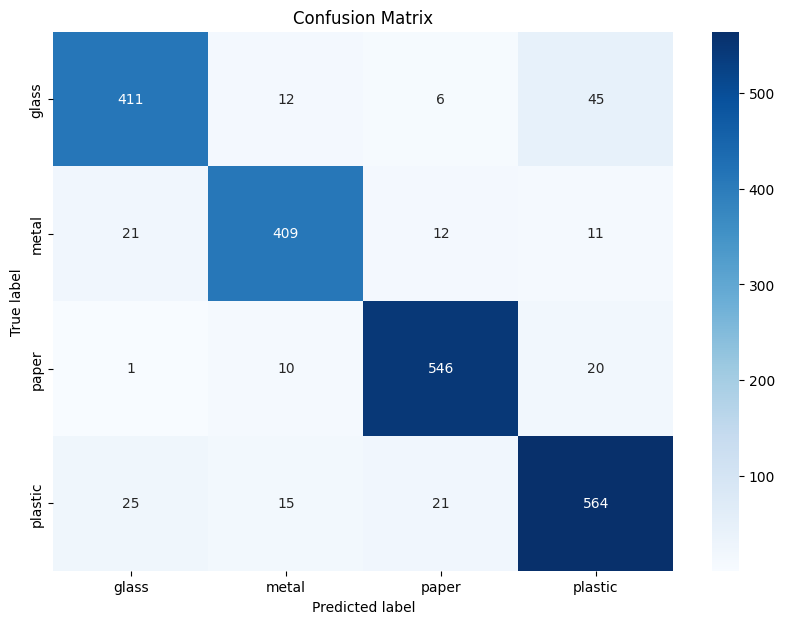

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on validation set
val_labels, val_preds = evaluate_model(model, dataloaders['val'])

# Calculate F1 score
report = classification_report(val_labels, val_preds, target_names=image_datasets['val'].classes)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=image_datasets['val'].classes, 
            yticklabels=image_datasets['val'].classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle

# Save model as a pickle file
with open('resnet50_trained_model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)
print("Model saved as resnet50_trained_model.pkl")


In [ ]:
!zip -r file.zip /kaggle/working

In [ ]:
!ls

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')